In [6]:
import infostop
import pandas as pd
import numpy as np
import os

import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(use_cache=True, log_console=True)
print(ox.__version__)

import networkx as nx
import geopandas as gpd
import multiprocessing as mp

from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon

import folium
from folium.plugins import Fullscreen, HeatMapWithTime, TimestampedGeoJson
from folium.plugins import TimestampedGeoJson, HeatMap, HeatMapWithTime

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

from IPython.display import display, HTML, Markdown, IFrame

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def print_df(df):
    return display(HTML(df.to_html()))

def percent_missing(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    missing_value_df.reset_index(drop=True, inplace=True)
    return missing_value_df

df = pd.read_csv('nearest_wo_home_by_hour.csv')
#print_df(df.head())

0.16.0


### Obtain nearest dataframe without home locations with "get_lean_df" method.

In [7]:
def get_lean_df(df, distance):
    df = pd.DataFrame(df.loc[df.dist_mt<=distance])
    df.reset_index(drop=True, inplace=True)
    df.drop(columns=['end','label','user_geometry','location_geometry','dist_mt','location','detail_location'], inplace=True)
    df.rename(columns={"start":"date", "duration_hours":"duration"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.date
    df['user'] = df['user'].apply(str)
    df['category'] = df['category'].apply(str)
    df = pd.DataFrame(df.groupby(by=["user", "category", "date"])["duration"].sum().reset_index())
    print("Attribute data types:\n",df.dtypes)
    print()
    print("Shape of data set: ", df.shape)
    print()
    print_df(df.head())
    return df
# Declare distance
DISTANCE = 20
df_out = get_lean_df(df, DISTANCE)

Attribute data types:
 user         object
category     object
date         object
duration    float64
dtype: object

Shape of data set:  (11000, 4)



,user,category,date,duration
0,0,Others,2014-01-04,1.259167
1,0,Sustenance,2014-01-03,0.518889
2,0,Sustenance,2014-01-04,2.593333
3,0,Sustenance,2014-01-05,5.606111
4,0,Sustenance,2014-01-11,2.994722


### Home locations dataframe

In [8]:
df_in = pd.read_csv('daily_home_hours.csv')
df_in.rename(columns={"start_date":"date", "duration_h":"duration"}, inplace=True)
df_in['user'] = df_in['user'].apply(str)
df_in["category"] = "Residence"
del df_in["label"]
df_in = df_in.groupby(by=["user", "category", "date"])["duration"].sum().reset_index()
#df_in.head()

In [9]:
final_df = df_in.append(df_out, ignore_index=True)
final_df.sort_values(by=["user", "date", "category"], inplace=True)
final_df.reset_index(inplace=True, drop=True)
#final_df.head()

### Weekend and Weekday dataframe

In [10]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_df['dayofweek'] = final_df['date'].apply(lambda x: x.weekday())
#print_df(final_df.head())
weekend_df = pd.DataFrame(final_df.loc[final_df['dayofweek'].isin([5, 6])])
weekend_df.reset_index(drop=True, inplace=True)
weekday_df = pd.DataFrame(final_df.loc[final_df['dayofweek'].isin([0, 1, 2, 3, 4])])
weekday_df.reset_index(drop=True, inplace=True)

### Distibution of users for each category throughout the month (Average hours/day)

In [11]:
categories = sorted(list(final_df.category.unique()))
weekday_mean = weekday_df.groupby(['user', 'date', 'category'])['duration'].mean().reset_index()
weekend_mean = weekend_df.groupby(['user', 'date', 'category'])['duration'].mean().reset_index()

rowCnt, colCnt = int(1), int(1)
fig_hist = make_subplots(rows=3, cols=3, subplot_titles=categories, vertical_spacing=0.13, horizontal_spacing=0.1)
first_time = 0
for cat in categories:
    weekday_cat = list(weekday_mean.loc[weekday_mean['category'] == cat]["duration"])
    weekend_cat = list(weekend_mean.loc[weekend_mean['category'] == cat]["duration"])
    if(first_time==0):
        fig_hist.append_trace(go.Histogram(x=weekday_cat, xbins=dict(start=1, end=24, size=1),\
                                       autobinx=False, histnorm='percent', marker_color="blue", name="Weekday",legendgroup='a'), rowCnt, colCnt)
        fig_hist.append_trace(go.Histogram(x=weekend_cat, xbins=dict(start=1, end=24, size=1), \
                                       autobinx=False, histnorm='percent', marker_color="red", name="Weekend",legendgroup='b'), rowCnt, colCnt)
        first_time += 1
    else:
        fig_hist.append_trace(go.Histogram(x=weekday_cat, xbins=dict(start=1, end=24, size=1),\
                                       autobinx=False, histnorm='percent', marker_color="blue", name="Weekday",showlegend=False), rowCnt, colCnt)
        fig_hist.append_trace(go.Histogram(x=weekend_cat, xbins=dict(start=1, end=24, size=1), \
                                       autobinx=False, histnorm='percent', marker_color="red", name="Weekend",showlegend=False), rowCnt, colCnt)
      
    colCnt += 1
    if(colCnt > 3):
        rowCnt += 1
        colCnt = 1
        
fig_hist.update_layout(height=800, width=1000, title_text="Histogram - Distibution of Users for Each Category throughout the Month ({} meters radius)".format(DISTANCE))
fig_hist.update_xaxes(title = "Bins (24 Hours)", showline=True, linewidth=1.5, linecolor='black', mirror=True, fixedrange=True, range=[0, 24])
fig_hist.update_yaxes(title = "Percentage of Counts", showline=True, linewidth=1.5, linecolor='black', mirror=True, ticksuffix = "%")
name = "Plotly_Distribution for Weekdays-Weekends"
fig_hist.write_image(name+"{}.png".format(DISTANCE))
fig_hist.write_html(name+"{}.html".format(DISTANCE), auto_open=True)
IFrame(name+"{}.html".format(DISTANCE), width=1100, height=600)

### Average Barplot & Boxplot for all users (Average hours/month)
#### Side by side for all categories

In [12]:
final_df['isweekend'] = np.where(final_df['dayofweek'].isin([5, 6]), 'Weekend', 'Weekday')
#final_df.head()

In [13]:
box_data = pd.DataFrame(final_df.groupby(['date', 'category', 'isweekend'])['duration'].mean().reset_index())
fig_box = px.box(box_data, x="category", y="duration", color="isweekend",\
            labels={"duration": "Average Hours/Day", "category": "Category", "isweekend": "Color Legend"}, \
            title="Box Plot Comparisons for Categories ({} meters radius)".format(DISTANCE))
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
name = "Plotly_BoxPlots"
fig_box.write_image(name+"{}.png".format(DISTANCE))
fig_box.write_html(name+"{}.html".format(DISTANCE), auto_open=True)
IFrame(name+"{}.html".format(DISTANCE), width=1000, height=700)

In [14]:
bar_data = pd.DataFrame(final_df.groupby(['category', 'isweekend'])['duration'].mean().reset_index())
fig_bar = px.bar(bar_data, x="category", y="duration", color="isweekend", barmode='group',\
            labels={"duration": "Average Hours/Day", "isweekend": "", "category": "Category"}, \
            title="Bar Plot Comparisons of Categories ({} meters radius)".format(DISTANCE))
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
name = "Plotly_BarPlots"
fig_bar.write_image(name+"{}.png".format(DISTANCE))
fig_bar.write_html(name+".html".format(DISTANCE), auto_open=True)
IFrame(name+".html".format(DISTANCE), width=1000, height=700)

### Monthly plot for each category (average hours/day)

In [16]:
line_plot_df = pd.DataFrame(final_df.groupby(by=["date", "category", "isweekend"])["duration"].mean().reset_index())
line_plot_df["is_weekend"] = line_plot_df["isweekend"].apply(lambda row: 0 if row == "Weekday" else 1)
#line_plot_df.head()

In [17]:
list_of_weekend_dates = [np.datetime_as_string(i)[0:10] for i in list(line_plot_df.loc[line_plot_df.is_weekend == 1].date.unique())]
#list_of_weekend_dates

In [18]:
fig_line = px.line(line_plot_df, x="date", y="duration", color='category',\
            labels={"duration": "Average Hours/Day", "date": "Date", "category": "Category"}, \
            title="Line Plot Comparisons of Categories ({} meters radius)".format(DISTANCE))
counter = int(0)
while(counter < len(list_of_weekend_dates)):
    fig_line.add_vrect(x0=list_of_weekend_dates[counter], x1=list_of_weekend_dates[counter+1],fillcolor="LightSalmon", \
                       opacity=0.4, layer="below", line_width=0)
    counter += 2
    
name = "Plotly_LinePlots"
fig_line.write_image(name+"{}.png".format(DISTANCE))
fig_line.write_html(name+"{}.html".format(DISTANCE), auto_open=True)
IFrame(name+"{}.html".format(DISTANCE), width=1100, height=500)

In [19]:
line_plot_pv = line_plot_df.pivot_table(index = ["date"], values=["duration"], columns=["category"])
#print_df(line_plot_pv)
line_plot_pv.columns = line_plot_pv.columns.droplevel()

area_plot = px.area(line_plot_pv, facet_col="category", facet_col_wrap=3,\
            labels={"value": "Average Hours/Day", "date": "Date", "category": "Category".replace("=", "")}, \
            title="Area Plot Comparisons of Categories ({} meters radius)".format(DISTANCE)\
                   )#.for_each_trace(lambda t: t.update(name=t.name.replace("=", "")))
area_plot.update_yaxes(title_font_size=11)
area_plot.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
counter = int(0)
while(counter < len(list_of_weekend_dates)):
    area_plot.add_vrect(x0=list_of_weekend_dates[counter], x1=list_of_weekend_dates[counter+1],fillcolor="LightSalmon", \
                       opacity=0.4, layer="below", line_width=0)
    counter += 2
area_plot.update_xaxes(showline=True, linewidth=1.2, linecolor='black', mirror=True)
area_plot.update_yaxes(showline=True, linewidth=1.2, linecolor='black', mirror=True)
#plotly.offline.iplot(area_plot)
name = "Plotly_AreaPlots"
area_plot.write_image(name+"{}.png".format(DISTANCE))
area_plot.write_html(name+"{}.html".format(DISTANCE), auto_open=True)
IFrame(name+"{}.html".format(DISTANCE), width=1100, height=600)

In [20]:
ml_df = pd.DataFrame(weekday_df.groupby(by=["user", "category"])["duration"].mean().reset_index().rename(columns={"duration":"weekday_mean_duration"}))
ml_df = pd.merge(ml_df, pd.DataFrame(weekend_df.groupby(by=["user", "category"])["duration"].mean().reset_index().rename(columns={"duration":"weekend_mean_duration"})), on=["user", "category"])

In [21]:
ml_pv = ml_df.pivot_table(index = ["user"], values=[i for i in list(ml_df.columns) if i not in ["user", "category"]], columns=["category"], fill_value="0")
ml_pv.columns = ml_pv.columns.map(lambda x: "|".join([str(i) for i in x]))
#print_df(ml_pv.head(15))

In [22]:
for col in list(ml_pv.columns):
    ml_pv[col] = ml_pv[col].apply(float)

In [23]:
X = pd.DataFrame(ml_pv.reset_index(drop=True))
y = pd.DataFrame(data=ml_pv.index, columns=["user"])
#print_df(X.head())
#print_df(y.head())

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

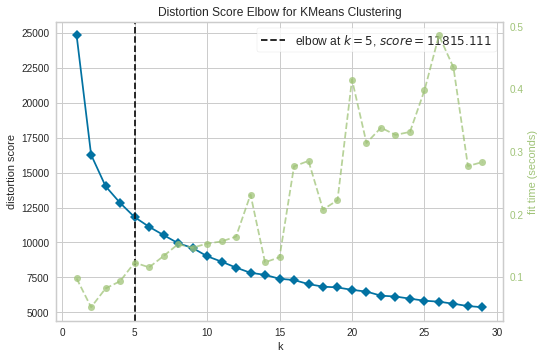

In [24]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,30))

visualizer.fit(ml_pv)        # Fit the data to the visualizer
visualizer.show(outpath="Distortion Score Elbow for KMeans Clustering.png")

In [25]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(ml_pv)
#print(len(kmeans.labels_))
#print(ml_pv.shape)
#kmeans.labels_

In [26]:
ml_pv.reset_index(inplace=True)
ml_pv['clusters'] = list(kmeans.labels_)
#ml_pv.head(10)

#### By default, the scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center. However, two other metrics can also be used with the KElbowVisualizer – silhouette and calinski_harabasz. The silhouette score calculates the mean Silhouette Coefficient of all samples, while the calinski_harabasz score computes the ratio of dispersion between and within clusters.